# Monthly Portfolio Rebalance

My Monthly Portfolio Rebalance strategy revolves around the trading of large capitalization stocks, specifically focusing on the constituent stocks of the Dow Jones Index Fund (DJI) as the eligible universe for our rebalancing. The initial portfolio comprises 6 carefully selected stocks, subject to a monthly turnover of 3 stocks, with trading occuring on a daily basis. 

To elaborate further, the portfolio will undergo a monthly rebalancing process, wherein the three weakest performing stocks will be replaced with the three highest performing stocks from the DJI universe. 

To rigorously access the efficacy of our strategy, we will backtest over a span of 10 years, employing historical stock data. The results of this backtest will be juxtaposed against a straightforward 'buy and hold' approach using the DJI. 

The evaluation of our strategy's performance will be based on the following quantitative finance metrics:
1. <strong>Compounded Annual Growth Rate (CAGR):</strong> This metric will gauge the annualized return achieved by our assets, expressing the growth in their market value from the initial investment.
2. <strong>Sharpe Ratio:</strong> By employing the Sharpe Ratio, we can measure the risk-adjusted relative returns of our equity, effectively comparing its performance to that of a 'theoretical' risk-free investment, exemplified by U.S. government treasury bonds.
3. <strong>Maximum Drawdown:</strong> A paramount indicator of downside risk over our designated time horizon, Maximum Drawdown concentrates on the most substantial percentage decline experienced by our asset's price. 

Here are various formulas used in our backtesting:

$$CAGR = \left[ {v_f } \over { v_i} \right]^{1 \over t} - 1$$
$v_i =$ Initial Value<br/>
$v_f =$ Final Value<br/>
$t =$ Time (years)<br/>

$$Sharpe \space Ratio = {{R_p - R_f} \over \sigma_p}$$
$R_p =$ Expected Returns <br />
$R_f =$ Risk Free rate of return <br />
$\sigma_p =$ Standard Deviation of Asset Returns<br /><br />

Note that we will use 3.9% as the risk-free investment rate of return, as it has been the average for the U.S. Treasury Bond for the past 10 years. 


Strategy CAGR: 0.08637866424632668
Strategy Sharpe Ratio: 0.29101957388508204
Strategy Max Drawdown: 0.3275187731032784

Index Buy CAGR: 0.08836110706668432
Index Buy Sharpe Ratio: 0.3312490373928482
Index Buy Max Drawdown 0.2320126616506341


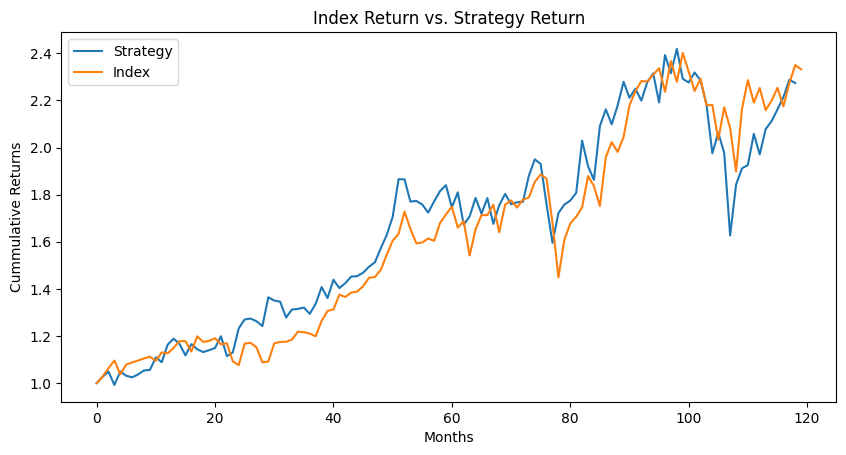

In [11]:
# -------------------------------------------------------------------------------
# Author: Daniel Xu
# Date: 08/03/2023
# Description: Backtesting for Monthly Portfolio Rebalance strategy on a large cap
#   universe of stocks, with a rebalancing frequency of 1 month
# -------------------------------------------------------------------------------

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import copy

# ------------------------- KPI FUNCTION DEFINITIONS --------------------------

# CAGR - takes in a DataFrame and computes the Compounded Average Growth Rate
def cagr(df):
    temp = df.copy()
    temp['Cumulative Returns'] = (1 + temp['Monthly Return']).cumprod()
    # decimal expression of years, based on number of trading months
    n = len(temp)/12
    CAGR = (temp['Cumulative Returns'].tolist()[-1])**(1/n) - 1
    return CAGR

# ANNUALIZED_MONTHLY_VOLATILITY - takes in stock dataframe, returns annualized monthly volatility
def annualized_monthly_volatility(df):
    temp = df.copy()
    vty = temp['Monthly Return'].std() * np.sqrt(12)
    return vty

# SHARPE - takes in DataFrame and Risk Free Rate of Return, returns sharpe ratio
def sharpe(df, rfr):
    shp = (cagr(df) - rfr) / annualized_monthly_volatility(df)
    return shp

# MAX_DRAWDOWN - returns the maximum drawdown of analyzed stock period
def max_drawdown(df):
    temp = df.copy()
    temp['Cumulative Return'] = (1 + temp['Monthly Return']).cumprod()
    temp['Cumulative Rolling Max'] = temp['Cumulative Return'].cummax()
    temp['Drawdown'] = temp['Cumulative Rolling Max'] - temp['Cumulative Return']
    md = (temp['Drawdown'] / temp['Cumulative Rolling Max']).max()
    return md

# -------------------- DATA DOWNLOAD FOR DOW JONES STOCKS ---------------------

tickers = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO',
           'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 
           'DIS', 'DOW']
stock_data = {}
# Start time 10 years back
start_time = dt.datetime.today() - dt.timedelta(3650)
end_time = dt.datetime.today()

for t in tickers:
    stock_data[t] = yf.download(t, start_time, end_time, interval='1mo', progress=False)
    stock_data[t].dropna(inplace=True, how='all')

# Remove tickers with corrupt data
tickers = stock_data.keys()

# ------------------------------- BACKTESTING -------------------------------

test_data = copy.deepcopy(stock_data)
monthly_returns = pd.DataFrame()

for t in tickers:
    monthly_returns[t] = test_data[t]['Adj Close'].pct_change()

# PORTFOLIO - produces monthly returns based on strategy
#   df - monthly returns DataFrame
#   stock - number of stock in portfolio
#   x - number of underperforming stock to be removed from portfolio
def portfolio(df, stock, x):
    temp = df.copy()
    pflo = []
    monthly_return = [0]
    for i in range(1, len(temp)):
        if len(pflo) > 0:
            # Calculate the monthly return of the portfolio by averaging the ith row (month) of the portfolio stock returns
            monthly_return.append(temp[pflo].iloc[i, :].mean())
            # Get dropped stocks array by sorting monthly returns from lowest to highest, and dropping the first 'x' values
            drops = temp[pflo].iloc[i, :].sort_values(ascending=True)[:x].index.values.tolist()
            # Update portfolio by filtering out dropped stocks
            pflo = [s for s in pflo if s not in drops]
        # Number of stocks that need to be filled in portfolio
        fill = stock - len(pflo)
        # Get added stocks array by sorting monthly returns from highest to lowest, and adding the first __ values to be filled
        adds = temp.iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
        pflo = pflo + adds
    final_monthly_returns = pd.DataFrame(np.array(monthly_return), columns=['Monthly Return'])
    return final_monthly_returns
        
# MONTHLY PORTFOLIO REBALANCING KPIs
print('\nStrategy CAGR:', cagr(portfolio(monthly_returns, 6, 3)))
print('Strategy Sharpe Ratio:', sharpe(portfolio(monthly_returns, 6, 3), 0.039))
print('Strategy Max Drawdown:', max_drawdown(portfolio(monthly_returns, 6, 3)))
        
# INDEX BUY AND HOLD KPI
dow_jones = yf.download('^DJI', dt.date.today() - dt.timedelta(3650), dt.date.today(), interval='1mo', progress=False)
dow_jones['Monthly Return'] = dow_jones['Adj Close'].pct_change().fillna(0)
print('\nIndex Buy CAGR:', cagr(dow_jones))
print('Index Buy Sharpe Ratio:', sharpe(dow_jones, 0.039))
print('Index Buy Max Drawdown', max_drawdown(dow_jones))
        

#---------------------------- DATA VISUALIZATION -----------------------------
fig, ax = plt.subplots()
plt.plot((1 + portfolio(monthly_returns, 6, 3)).cumprod())
plt.plot((1 + dow_jones['Monthly Return'].reset_index(drop=True)).cumprod())
plt.title('Index Return vs. Strategy Return')
plt.ylabel('Cummulative Returns')
fig.set_figwidth(10)
plt.xlabel('Months')
ax.legend(['Strategy', 'Index'])

As depicted in the graph, the performance of the strategy exhibits a close resemblance to that of the DJI. Although transient gains are noticeable, the CAGR calculations reveal that the strategy yields comparatively lower returns. Both entities exhibit mediocre Sharpe Ratios, hovering around 0.3. However, the index buy demonstrates a superior Sharpe Ratio in comparison to the strategy, signifying a better risk-adjusted return for holding a volatile asset. The strategy displays a larger Maximum Drawdown, indicating a higher downside risk. 

This observation is evident in the graph, as the strategy performs well overall until reaching the 100-month mark, where returns dip significantly. Notably, this period coincided with the outbreak of the COVID-19 pandemic, which profoundly impacted the global economy. The pandemic serves as a real-world instance of an unpredictable event that defied models and trading strategies, underscoring one of the primary hazards of relying solely on financial strategies for trading decisions. Subsequently, as the economy recuperates, the strategy's returns show signs of convergence with the index returns.

Ultimately, if we were to treat the 100-120 month period as an outlier, the strategy demonstrates commendable performance during the 0-100 month duration, as depicted in the graph. Furthermore, it becomes apparent that the economy regains stability the strategy's cumulative returns outplace those of the index fund at a swifter pace. 